# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [ ]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
n = 100
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:n]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:n]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences][:n]

Double check by plotting

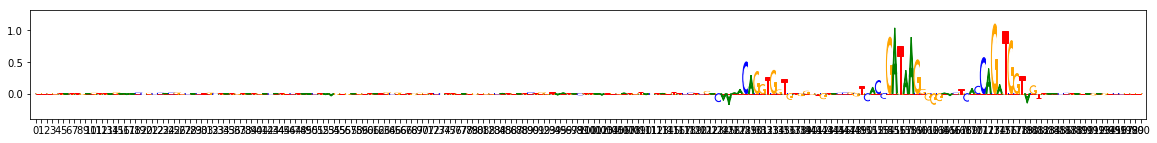

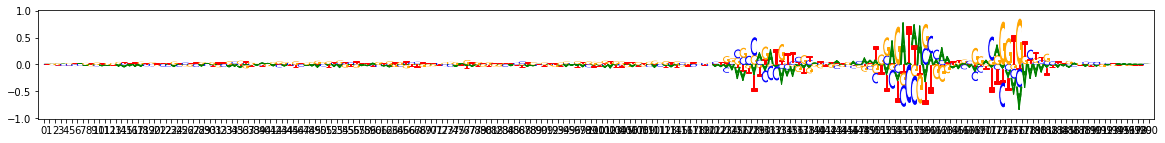

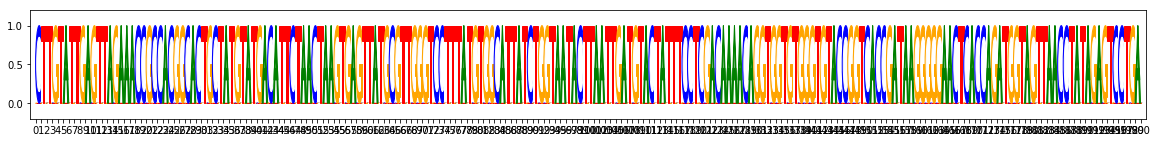

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqelts. For a particular task, "significant" seqlets are identified by fitting a laplace distribution to the left and right tails of the values obtained after smoothing the importance scores with a window of size `sliding_window_size`. This laplace distribution is assumed to represent the null distribution of random seqlet importance scores. A threshold is then identified such that the false discovery rate (computed as the ratio of the expected number of seqlets according to the laplace null to the observed number of seqlets above the threshold) is less that `target_seqlet_fdr`. This is what is meant by "Est. FDR" printed in the logs below. If "Est. FDR" is above the target threshold, that means there was no significant increase in the number of seqlets relative to the null. You'll see below that "Est. FDR" for negative scores for any task is above this threshold, which fits with the simulation because there were no "negative set" motifs.

On task task0
Computing windowed sums
Computing threshold
peak(mu)= -0.02237088233232498
Mu: -2.237088e-02 +/- 4.715286e-06
Lablace_b: 0.153312649590169 and 0.22064684170499915
Thresholds: -1.1321076825261116 and 1.337173156440258
#fdrs pass: 0 and 2355
CDFs: 0.9992815326745691 and 0.9978911853628061
Est. FDRs: 1.0 and 0.009918145667722018


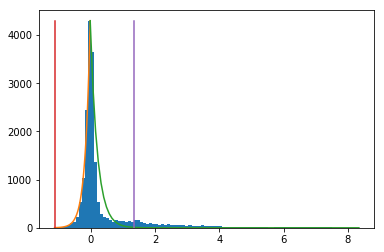

Got 154 coords
On task task1
Computing windowed sums
Computing threshold
peak(mu)= -0.00025500368792563677
Mu: -2.550037e-04 +/- 5.242706e-06
Lablace_b: 0.13286657599035873 and 0.12052453829806092
Thresholds: -1.40356351446826 and 0.7425463049439713
#fdrs pass: 0 and 1863
CDFs: 0.9999741134562105 and 0.99789422388979
Est. FDRs: 0.2536621689796448 and 0.009947899139125822


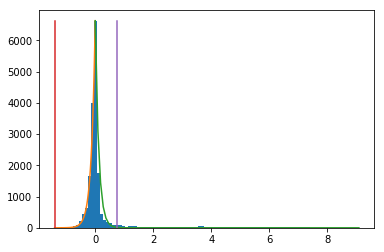

Got 117 coords
On task task2
Computing windowed sums
Computing threshold
peak(mu)= -0.003469625487923622
Mu: -3.469625e-03 +/- 6.540795e-06
Lablace_b: 0.10298308304839991 and 0.12131523830071525
Thresholds: -1.0811202725155116 and 0.7402334418147802
#fdrs pass: 20 and 2136
CDFs: 0.9999714640633187 and 0.9978241483572216
Est. FDRs: 0.009762586309359623 and 0.009886070137166799


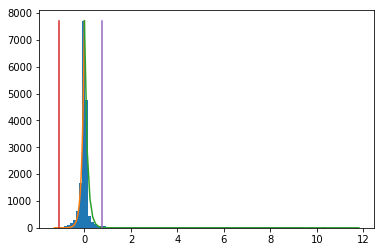

Got 120 coords
After resolving overlaps, got 221 seqlets
Across all tasks, the weakest laplace threshold used was: 0.9978241483572216
221 identified in total
2 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [0, 0]
Idx to activities:  {0: '0,0,1', 1: '0,1,0'}
On metacluster 0
Metacluster size 0
Relevant tasks:  ('task2',)
Relevant signs:  (1,)
(Round 1) num seqlets: 110
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.15 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 0.44 s
Launchi

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.09606289864 seconds
Wrote graph to binary file in 0.00639796257019 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.686624
After 5 runs, maximum modularity is Q = 0.693896
Louvain completed 55 runs in 0.709504127502 seconds
Preproc + Louvain took 1.8639061451 s
Got 6 clusters after round 1
Counts:
{0: 27, 1: 26, 2: 17, 3: 13, 4: 12, 5: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 27 seqlets
Trimmed 0 out of 27
Skipped 1 seqlets
Aggregating for cluster 1 with 26 seqlets
Trimmed 0 out of 26
Skipped 6 seqlets
Aggregating for cluster 2 with 17 seqlets
Trimmed 0 out of 17
Skipped 2 seqlets
Aggregating for cluster 3 with 13 seqlets
Trimmed 0 out of 13
Skipped 1 seqlets
Aggregating for cluster 4 with 12 seqlets
Trimmed 0 out of 12
Skipped 2 seqlets
Aggregating for cluster 5 with 11 seqlets
Trimmed 0 out of 11
(Round 2) num seqlets: 87
(Round 2) Computing coarse affmat
Beginning embeddi

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.08447194099 seconds
Wrote graph to binary file in 0.00534796714783 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.713184
Louvain completed 51 runs in 0.647971868515 seconds
Preproc + Louvain took 1.7754881382 s
Got 6 clusters after round 2
Counts:
{0: 20, 1: 16, 2: 15, 3: 14, 4: 13, 5: 9}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 20 seqlets
Trimmed 1 out of 20
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 2 with 15 seqlets
Trimmed 0 out of 15
Aggregating for cluster 3 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 4 with 13 seqlets
Trimmed 0 out of 13
Aggregating for cluster 5 with 9 seqlets
Trimmed 0 out of 9
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 2 & 3 with prob 3.5957088655102995e-05 an

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.10018610954 seconds
Wrote graph to binary file in 0.00705003738403 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.744689
After 2 runs, maximum modularity is Q = 0.745051
Louvain completed 52 runs in 0.673443078995 seconds
Preproc + Louvain took 1.81936097145 s
Got 6 clusters after round 1
Counts:
{0: 23, 1: 19, 2: 18, 3: 17, 4: 13, 5: 12}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 23 seqlets
Trimmed 1 out of 23
Aggregating for cluster 1 with 19 seqlets
Trimmed 1 out of 19
Aggregating for cluster 2 with 18 seqlets
Trimmed 0 out of 18
Skipped 1 seqlets
Aggregating for cluster 3 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 4 with 13 seqlets
Trimmed 0 out of 13
Aggregating for cluster 5 with 12 seqlets
Trimmed 0 out of 12
Skipped 2 seqlets
(Round 2) num seqlets: 97
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embeddin

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.08184313774 seconds
Wrote graph to binary file in 0.00749897956848 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.738748
Louvain completed 51 runs in 0.66571688652 seconds
Preproc + Louvain took 1.79448986053 s
Got 10 clusters after round 2
Counts:
{0: 22, 1: 16, 2: 13, 3: 10, 4: 10, 5: 8, 6: 8, 7: 4, 8: 4, 9: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 22 seqlets
Trimmed 2 out of 22
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 2 with 13 seqlets
Trimmed 1 out of 13
Aggregating for cluster 3 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 4 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 5 with 8 seqlets
Trimmed 0 out of 8
Skipped 1 seqlets
Aggregating for cluster 6 with 8 seqlets
Trimmed 0 out of 8
Aggregating for cluster 7 with 4 seqlets
Trimmed 0 out of 4
Aggregating for cluster 8 with 4 seqlets
Trimmed 0 out o

In [7]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.01,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

## Save Results

In [8]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)
grp.close()

## Print results

Metaclusters heatmap


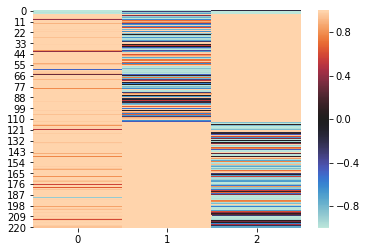

metacluster_0
activity pattern: [0 0 1]
metacluster_0 pattern_0
total seqlets: 84
Task 0 hypothetical scores:


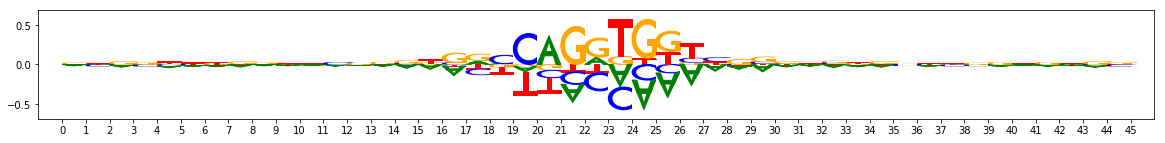

Task 0 actual importance scores:


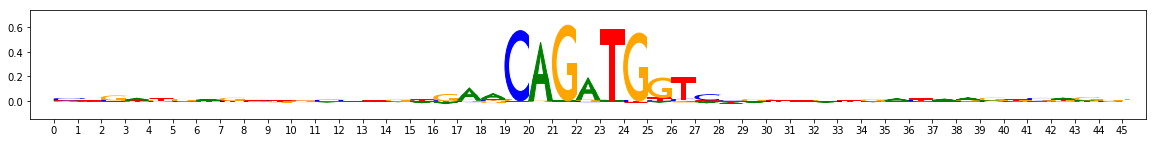

Task 1 hypothetical scores:


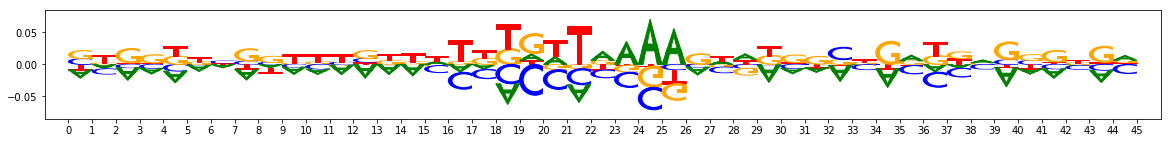

Task 1 actual importance scores:


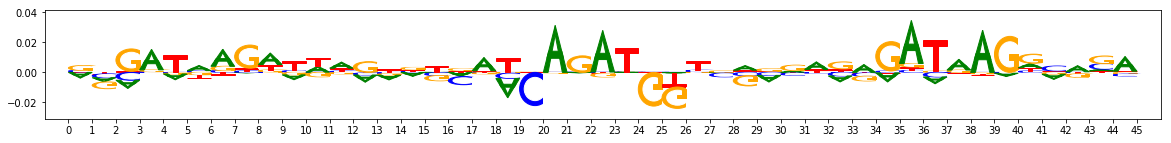

Task 2 hypothetical scores:


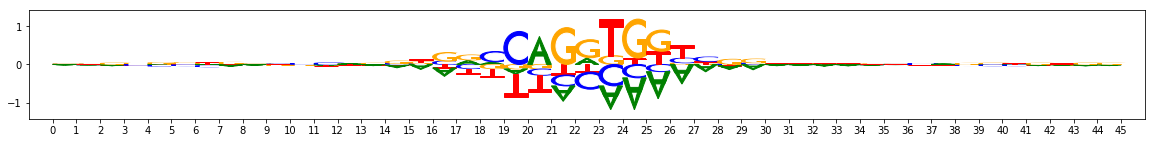

Task 2 actual importance scores:


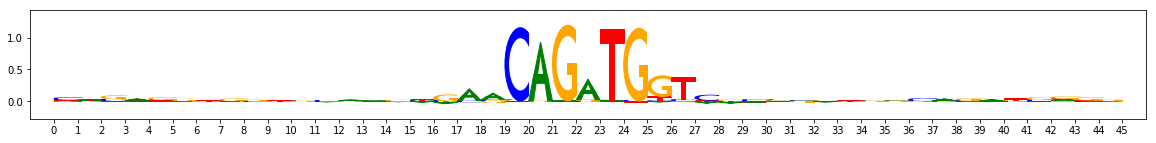

onehot, fwd and rev:


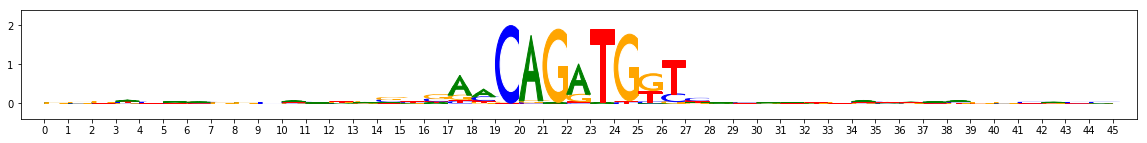

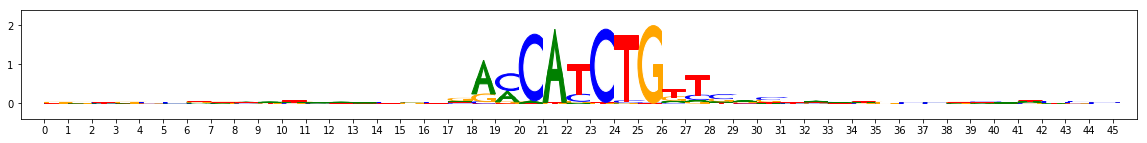

metacluster_1
activity pattern: [0 1 0]
metacluster_1 pattern_0
total seqlets: 80
Task 0 hypothetical scores:


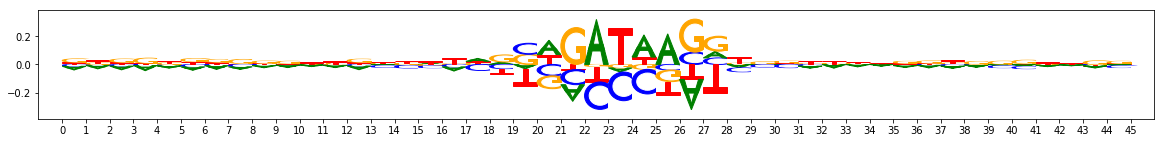

Task 0 actual importance scores:


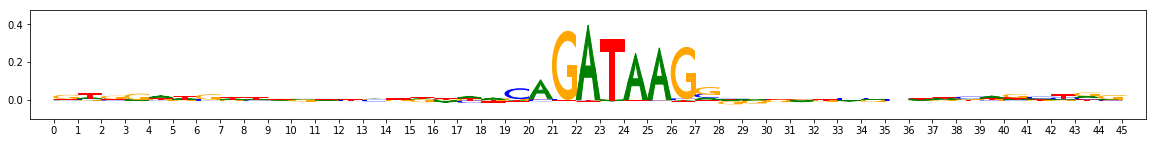

Task 1 hypothetical scores:


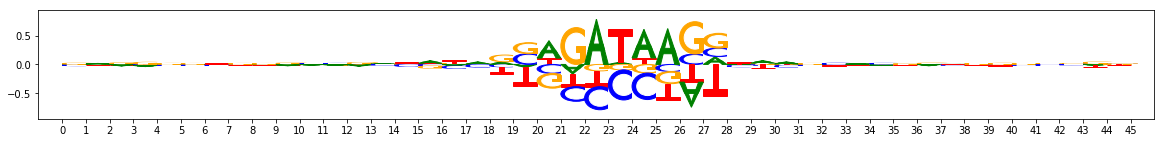

Task 1 actual importance scores:


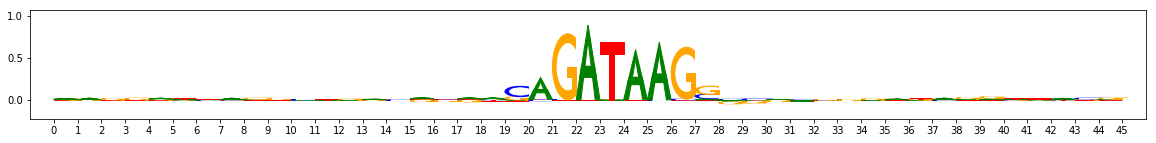

Task 2 hypothetical scores:


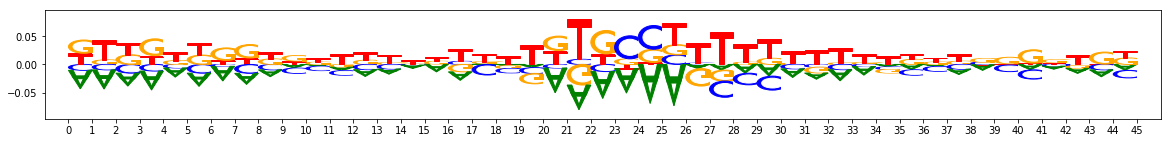

Task 2 actual importance scores:


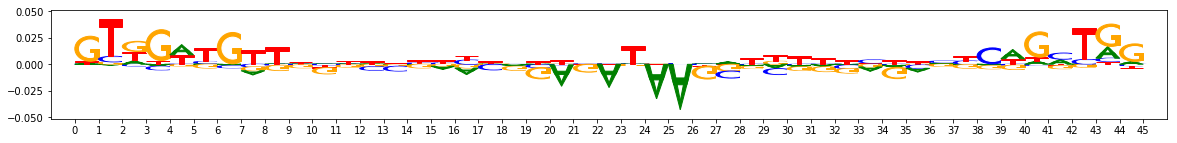

onehot, fwd and rev:


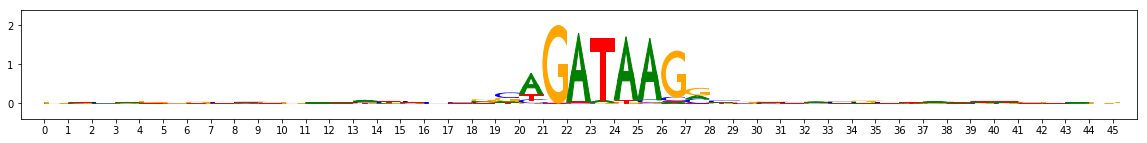

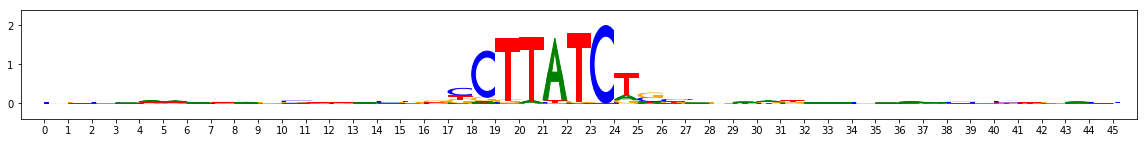

In [17]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Load the saved hdf5 file

Load the results object from the saved file

In [10]:
import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=tasks,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

## Prepare hit scorers

Prepare a seqlet scorer (`max_rank_based_pattern_scorer`)

In [11]:
from modisco import affinitymat
reload(affinitymat.core)
reload(affinitymat)
from modisco import hit_scoring
reload(hit_scoring.fast_hit_scoring)
reload(hit_scoring)
from collections import OrderedDict

task_names = ["task0", "task1", "task2"]

seqlet_size_to_score_with = 25

metacluster_idx_to_scorer = OrderedDict()

all_pattern_scorers = []
all_pattern_names = []

for metacluster_name in\
    sorted(loaded_tfmodisco_results
           .metacluster_idx_to_submetacluster_results.keys()):
    submetacluster_results =(
        loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results[metacluster_name])
    activity_pattern = submetacluster_results.activity_pattern
    relevant_task_names = [task_name for (task_name,x) in
                           zip(task_names, activity_pattern) if np.abs(x) != 0]
    
    patterns_in_submetacluster =\
        submetacluster_results.seqlets_to_patterns_result.patterns
 
    pattern_comparison_settings = affinitymat.core.PatternComparisonSettings(
        track_names=([x+"_contrib_scores" for x in relevant_task_names]
                     +[x+"_hypothetical_contribs" for x in relevant_task_names]),
        track_transformer=affinitymat.L1Normalizer(),
        min_overlap=0.7)

    pattern_to_seqlets_sim_computer = hit_scoring.PatternsToSeqletsSimComputer(
        pattern_comparison_settings=pattern_comparison_settings,
        cross_metric_computer=\
            affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                n_cores=1,
                cross_metric_single_region=
                    affinitymat.core.CrossContinJaccardSingleRegionWithArgmax(),
                verbose=False),
        seqlet_trimmer=modisco.hit_scoring.SeqletTrimToBestWindow(
                        window_size=seqlet_size_to_score_with,
                        track_names=[x+"_contrib_scores" for x
                                     in relevant_task_names]))

    #Get a list of scorers for all the patterns in the metacluster
    metacluster_pattern_scorers = []
    for pattern_idx, pattern in\
        enumerate(submetacluster_results.
                   seqlets_to_patterns_result.patterns):
        metacluster_idx = int(metacluster_name.split("_")[1])
        all_pattern_names.append("metacluster_"+str(metacluster_idx)
                             +",pattern_"+str(pattern_idx))
        pattern_scorer = hit_scoring.RankBasedPatternScorer(
                aggseqlets=pattern,
                patterns_to_seqlets_sim_computer=
                    pattern_to_seqlets_sim_computer)
        metacluster_pattern_scorers.append(pattern_scorer)
        all_pattern_scorers.append(pattern_scorer)
    #This is the final scorer for the metacluster;
    # it takes the maximum score produced by all the
    # individual scorers
    max_rank_based_pattern_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                        pattern_scorers=metacluster_pattern_scorers)
    metacluster_idx_to_scorer[metacluster_idx] = max_rank_based_pattern_scorer
cross_metacluster_scorer = hit_scoring.MaxRankBasedPatternScorer(
                                pattern_scorers=all_pattern_scorers)

Test it out...prepare a bunch of seqlets to score using the original patterns

In [12]:
from sklearn.metrics import confusion_matrix
all_patterns = [x for y in
                  sorted(loaded_tfmodisco_results
                  .metacluster_idx_to_submetacluster_results.keys())
                  for x in
                   loaded_tfmodisco_results
                   .metacluster_idx_to_submetacluster_results[y]
                   .seqlets_to_patterns_result.patterns]
seqlets_to_score = []
seqlets_to_score_true_labels = []
for i,pattern in enumerate(all_patterns):
    seqlets_to_score.extend(pattern.seqlets)
    seqlets_to_score_true_labels.extend(
        [i for x in pattern.seqlets])

Now score the seqlets (we will use the cross-metacluster scorer here)

In [13]:
pattern_scores_for_each_seqlet = cross_metacluster_scorer(seqlets_to_score)
seqlets_to_score_predicted_labels =\
    [x.pattern_idx for x in pattern_scores_for_each_seqlet]
confusion_mat = confusion_matrix(y_true = seqlets_to_score_true_labels,
                                 y_pred = seqlets_to_score_predicted_labels)
print(all_pattern_names)
print(confusion_mat.astype("float")/np.sum(confusion_mat,axis=1)[:,None])

['metacluster_0,pattern_0', 'metacluster_1,pattern_0']
[[0.95238095 0.04761905]
 [0.025      0.975     ]]


## Obtain seqlets from data

In [14]:
per_position_contrib_scores = OrderedDict([                             
    (x, [np.sum(s,axis=1) for s in task_to_scores[x]]) for x in tasks])
seqlets_from_data =(
    loaded_tfmodisco_results.multitask_seqlet_creation_results.multitask_seqlet_creator(
        task_name_to_score_track=per_position_contrib_scores,           
        track_set=track_set,
        task_name_to_thresholding_results=
            loaded_tfmodisco_results
             .multitask_seqlet_creation_results
             .task_name_to_thresholding_results)).final_seqlets

On task task0
Computing windowed sums
Got 154 coords
On task task1
Computing windowed sums
Got 117 coords
On task task2
Computing windowed sums
Got 120 coords
After resolving overlaps, got 221 seqlets


## Map seqlets to metacluster, then to a pattern

In [16]:
from collections import defaultdict, OrderedDict

metacluster_indices = loaded_tfmodisco_results.metaclustering_results.metaclusterer.transform(
                                    seqlets_from_data).metacluster_indices

metacluster_to_seqlets = defaultdict(list)
for a_seqlet, metacluster_idx in zip(seqlets_from_data, metacluster_indices):
    metacluster_to_seqlets[metacluster_idx].append(a_seqlet)

metacluster_to_seqlet_pattern_matches = OrderedDict() 
for metacluster_idx in metacluster_idx_to_scorer:
    metacluster_to_seqlet_pattern_matches[metacluster_idx] =\
        metacluster_idx_to_scorer[metacluster_idx](metacluster_to_seqlets[metacluster_idx])